In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

import tensorflow as tf
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [2]:
import glob
uav_path = '../data/phantom/JUNE_01_PHANTOMS/wavs/22050/*.*'
none_path = '../data/phantom/JUNE_02_BACKGROUND/wavs/background/22050/background_*.*'
uav_files = glob.glob(uav_path)
none_files = glob.glob(none_path)

In [3]:
print(len(uav_files),'개\t', uav_files[0])
print(len(none_files), '개\t',none_files[0])

22 개	 ../data/phantom/JUNE_01_PHANTOMS/wavs/22050\LGgram_P2_loaded bck and forth.wav
25 개	 ../data/phantom/JUNE_02_BACKGROUND/wavs/background/22050\background_06_02_01.WAV


# Load Data

The reason of why SR is 44100 is that the sample rate of above files is 44.1kbps

a wav file sample has 884736. if sample is divided by sample rate, the value is time
the time is fixed by 20.06

In [4]:
def load(files, sr=44100):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
SR = 22050
uav_raw = load(uav_files)
none_raw = load(none_files)


(75718272,)
(21921792,)


# Feature extraction 
## steps
#### 1. Resampling 
#### 2. *VAD*( Voice Activity Detection)
#### 3. Maybe padding with 0 to make signals be equal length
#### 4. Log spectrogram (or *MFCC*, or *PLP*)
#### 5. Features normalization with *mean* and *std*
#### 6. Stacking of a given number of frames to get temporal information



## 1. Resampling

if you see the graph, there are few at high frequency. this is mean that data is big but it's no useless. so To small the data, do Resampling. In general, use 0~8000Hz 

In [6]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [7]:
def showFreqTime(combine):
    for sample, filename, _ in combine:
        freqs, times, spectrogram = log_specgram(sample, SR)
        fig = plt.figure(figsize=(14, 10))
        ax1 = fig.add_subplot(211)
        ax1.set_title('Raw wave of ' + filename)
        ax1.set_ylabel('Amplitude')
        ax1.plot(np.linspace(0, len(sample)/SR, len(sample)), sample)

        ax2 = fig.add_subplot(212)
        ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
        ax2.set_yticks(freqs[::16])
        ax2.set_xticks(times[::16])
        ax2.set_title('Spectrogram of ' + filename)
        ax2.set_ylabel('Freqs in Hz')
        ax2.set_xlabel('Seconds')

In [8]:
#showFreqTime(combine)

In [9]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

### Data diffrence

qualiy is diffrence but, the data is almost same.

In [10]:
#ipd.Audio(combine_prev[0][0], rate=combine_prev[0][2])

In [11]:
#ipd.Audio(combine[0][0], rate=combine[0][2])

## 2. VAD

Sometimes, Files have silence. It is not necessary. So, We need to find sound of Drone except silence.

But, Not yet implemented

## 3. padding with 0 to make signals be equal length

If we have a lot of sound files, we need to pad some datas. But These files's time is longger than 1 second. So It dosn't need to pad

## 4. Log spectrogram (or MFCC, or PLP)

The upper picture is resampled data. 
The lower picture is original data.

In MFCC Feature, There is no big difference. 

In [12]:
from scipy.stats import skew
#returns mfcc features with mean and standard deviation along time
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=22050, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc* n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print("small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        #print(mfcc_slice.shape)
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0]* mfcc_slice.shape[1]))
        #print(mfcc_slice.shape)
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [13]:
mfcc_uav, y_uav = mfcc4(uav_raw, 1)
print(mfcc_uav.shape, y_uav.shape)
mfcc_none, y_none = mfcc4(none_raw, 0)
print(mfcc_none.shape, y_none.shape)


(75718272,)
small end: (16, 16)
small end: (16, 8)
(18484, 256) (18484,)
(21921792,)
small end: (16, 9)
(5351, 256) (5351,)


In [14]:
print(mfcc_uav.shape, y_uav.shape)
print(mfcc_none.shape, y_none.shape)

(18484, 256) (18484,)
(5351, 256) (5351,)


## 5. Features normalization with *mean* and *std*

## 6. Stacking of a given number of frames to get temporal information

In [15]:
X = np.concatenate((mfcc_uav, mfcc_none), axis=0)
y = np.hstack((y_uav, y_none))
print(X.shape, y.shape)
X = np.reshape(X,(X.shape[0],-1))# 선범 
X.shape


(23835, 256) (23835,)


(23835, 256)

In [16]:
# or should we give one label to one chunk?
y_uav = np.ones(shape = [len(X)], dtype=int)
y_none =np.zeros(shape =[len(y)], dtype=int)

print(y_uav.shape)
print(y_none.shape)

(23835,)
(23835,)


In [17]:
dataX = X
dataY = y

In [18]:
print(dataX.shape, dataY.shape)

(23835, 256) (23835,)


In [19]:
seq_length = 9 #layer
X_hot_list= []
#Y_hot = dataY[seq_length-1:].reshape(len(dataY[seq_length-1:]), 1)
Y_hot_tmp = dataY[seq_length-1:]

for i in range(0, dataX.shape[0] - seq_length+1):
    _x = dataX[i:i + seq_length]
    #if i<10:
        #print(_x, "->", Y_hot_tmp[i])
    X_hot_list.append(_x)

X_hot = np.array(X_hot_list[:])
Y_hot = Y_hot_tmp.reshape((len(Y_hot_tmp),1))
print(X_hot.shape, Y_hot.shape)


(23827, 9, 256) (23827, 1)


In [20]:
X_dim = 256
X_train = np.zeros(shape=[0,9,X_dim],dtype=float)
y_train = np.zeros(shape=[0,1],dtype=float)
X_test = np.zeros(shape=[0,9,X_dim],dtype=float)
y_test = np.zeros(shape=[0,1],dtype=float)

split_rate = 0.9
none_len = len(y_none)
uav_len = len(X_hot) - none_len
print('uav_len, none_len', uav_len,none_len)

train_size = int(uav_len * split_rate)
test_size = uav_len - train_size
base = 0
print('train_uav, test_uav',train_size,test_size)

X_tr, X_te = np.array(X_hot[base:base+train_size]),np.array(X_hot[base+train_size:base+train_size+test_size])
y_tr, y_te = np.array(Y_hot[base:base+train_size]),np.array(Y_hot[base+train_size:base+train_size+test_size])
print(X_tr.shape,X_te.shape)
print(y_tr.shape,y_te.shape)

X_train = np.vstack((X_train,X_tr))
X_test= np.vstack((X_test,X_te))
y_train= np.vstack((y_train,y_tr))
y_test= np.vstack((y_test,y_te))

train_size = int(none_len * split_rate)
test_size = none_len - train_size
base = uav_len
print('none',train_size,test_size)

X_tr, X_te = np.array(X_hot[base:base+train_size]),np.array(X_hot[base+train_size:base+train_size+none_len])
y_tr, y_te = np.array(Y_hot[base:base+train_size]),np.array(Y_hot[base+train_size:base+train_size+none_len])
print(X_tr.shape,X_te.shape)
print(y_tr.shape,y_te.shape)

print(base+none_len)
X_train = np.vstack((X_train,X_tr))
X_test= np.vstack((X_test,X_te))
y_train= np.vstack((y_train,y_tr))
y_test= np.vstack((y_test,y_te))

uav_len, none_len -8 23835
train_uav, test_uav -7 -1
(23820, 9, 256) (0, 9, 256)
(23820, 1) (0, 1)
none 21451 2384
(0, 9, 256) (2384, 9, 256)
(0, 1) (2384, 1)
23827


In [21]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(23820, 9, 256) (2384, 9, 256)
(23820, 1) (2384, 1)


In [22]:
'''
np.save('../data/Xy/X_train2', X_train)
np.save('../data/Xy/X_test2', X_test)
np.save('../data/Xy/y_train2', y_train)
np.save('../data/Xy/y_test2', y_test)
'''

"\nnp.save('../data/Xy/X_train2', X_train)\nnp.save('../data/Xy/X_test2', X_test)\nnp.save('../data/Xy/y_train2', y_train)\nnp.save('../data/Xy/y_test2', y_test)\n"

In [23]:
'''
X_train = np.load('../data/Xy/X_train2.npy')
X_test = np.load('../data/Xy/X_test2.npy')
y_train = np.load('../data/Xy/y_train2.npy')
y_test = np.load('../data/Xy/y_test2.npy')
'''

"\nX_train = np.load('../data/Xy/X_train2.npy')\nX_test = np.load('../data/Xy/X_test2.npy')\ny_train = np.load('../data/Xy/y_train2.npy')\ny_test = np.load('../data/Xy/y_test2.npy')\n"

# Tensorflow RNN

## Train 

In [24]:
learning_rate = 0.01

# train Parameters
#X_dim = 442 #n_dim #X_hot.shape[2]

#seq_length = #X_hot.shape[1]
output_dim = 1 #n_classes #Y_hot.shape[1]

hidden_dim = 2

In [25]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, X_dim], name = 'X')
Y = tf.placeholder(tf.float32, [None, output_dim], name = 'Y')

#X_one_hot = tf.one_hot(X, )
# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
#cell = tf.contrib.rnn.MultiRNNCell([cell]*2, state_is_tuple=True)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Y_pred, labels = Y))

# optimizer
lr = tf.placeholder(tf.float32,shape=(), name='learning_rate')
train = tf.train.AdamOptimizer(lr).minimize(loss) #AdamOptimizer

# RMSE
targets = tf.placeholder(tf.float32, [None, output_dim] , name = 'targets')
predictions = tf.placeholder(tf.float32, [None, output_dim] , name = 'predictions')
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [26]:
X_train[0]

array([[-217.22691805, -225.90947428, -259.03216283, ...,   -6.84148284,
          -9.83497063,   -5.24579655],
       [-204.09500396, -216.19582211, -246.3247065 , ...,   -5.0652497 ,
          -2.52530122,   -2.09315019],
       [-223.15359868, -231.14346908, -256.00372179, ...,    2.70678687,
          -0.94429221,   -5.53733516],
       ...,
       [-247.48963791, -247.07030972, -248.1789639 , ...,   -4.28789018,
          -1.23542643,   -0.38626453],
       [-197.79129797, -211.73574008, -244.0251253 , ...,   -1.52421738,
          -1.52261091,    1.54296295],
       [-232.30992305, -232.90745687, -232.78914617, ...,   -6.58980176,
         -11.48347484,   -8.32239321]])

In [27]:
init = tf.global_variables_initializer()
cost_history = np.empty(shape=[1],dtype=float)
step_loss = 999999.0
model_path = '../models/RNN/my_RNN_model_S9_40'
saver = tf.train.Saver()
training_epochs = 10
# Training step

sess = tf.InteractiveSession()
sess.run(init)
for learning_rate in [0.02, 0.015, 0.01, 0.005]:
    test_acc = []
    feed = {lr:learning_rate, X: X_train, Y: y_train}
    for i in range(training_epochs):
        step_loss_prev = step_loss
        _, step_loss = sess.run([train, loss], feed_dict=feed)
        cost_history = np.append(cost_history,step_loss/X_train.shape[0])
        
        print("[step: {}] loss: {}".format(i, step_loss/X_train.shape[0]))
        #batch_acc, test_state = sess.run([loss, _states], feed_dict=feed)
    print("Test accuracy: {:.3f}".format(1.0-np.mean(cost_history)))

saver.save(sess, model_path)
sess.close()

[step: 0] loss: 2.132034037835852
[step: 1] loss: 0.7450620867443325
[step: 2] loss: 0.7165224371589001
[step: 3] loss: 0.6891175187604954
[step: 4] loss: 0.6624723676269941
[step: 5] loss: 0.6366240865737826
[step: 6] loss: 0.611533399913413
[step: 7] loss: 0.5872174446368598
[step: 8] loss: 0.5636617075986566
[step: 9] loss: 0.5408871385652813
Test accuracy: 1.040
[step: 0] loss: 0.5189082096846138
[step: 1] loss: 0.5029531381192276
[step: 2] loss: 0.4874519098315491
[step: 3] loss: 0.4724406846924853
[step: 4] loss: 0.4578638289777498
[step: 5] loss: 0.44375397676584805
[step: 6] loss: 0.4300951799958018
[step: 7] loss: 0.41689772906171285
[step: 8] loss: 0.40414547091467257
[step: 9] loss: 0.39185472259393367
Test accuracy: 0.805
[step: 0] loss: 0.3799814526920655
[step: 1] loss: 0.3723411835511125
[step: 2] loss: 0.36489807180153233
[step: 3] loss: 0.35766605662258605
[step: 4] loss: 0.3506384554077456
[step: 5] loss: 0.34381824048200044
[step: 6] loss: 0.33719592090417716
[step: 

In [28]:
sess = tf.InteractiveSession()
saver.restore(sess, model_path)

# Test step
test_predict = sess.run(Y_pred, feed_dict={X: X_train})
rmse_val = sess.run(rmse, feed_dict={
                    targets: y_train, predictions: test_predict})
print("RMSE: {}".format(rmse_val))

y_pred = sess.run(Y_pred,feed_dict={X: X_test})
y_pred[y_pred<0.5] = 0
y_pred[y_pred>=0.5] = 1
print(y_pred)
y_true = y_test
print(y_pred.shape, y_true.shape)

INFO:tensorflow:Restoring parameters from ../models/RNN/my_RNN_model_S9_40
RMSE: 0.5349453091621399
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(2384, 1) (2384, 1)


In [29]:
sess.close()

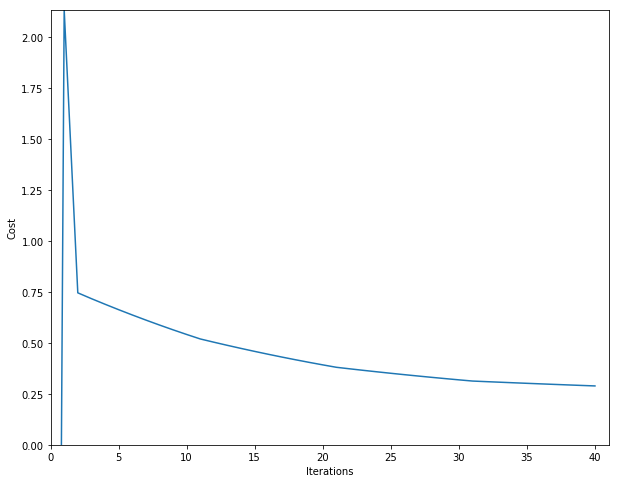

F-Score: 1.0
Accuracy:  1.0
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      2384

avg / total       1.00      1.00      1.00      2384

[[2384]]


In [30]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations") 
plt.axis([0,len(cost_history),0,np.max(cost_history)])
plt.show()


p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
print("Accuracy: ", accuracy_score(y_true, y_pred))

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

In [31]:
model_path_f = '../models/RNN/'
filename = 'my_RNN_model_S9_40.meta'


sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
loader = tf.train.import_meta_graph(model_path_f+filename)
loader.restore(sess, tf.train.latest_checkpoint(model_path_f))

SR = 22050
####
justone = True

while(justone):
    justone = False
    #print("start to record the audio.")
    '''
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    #print("Recording finished.")
    stream.stop_stream()
    stream.close()

    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    '''
    ####
    filename1 = '../data/phantom/JUNE_01_PHANTOMS/wavs/22050/WSU_P2_LOADED_BACK_AND_FORTH.wav'
    filename2 = '../data/phantom/JUNE_02_BACKGROUND/wavs/background/canopy_heavy_wind.wav'
    
    sample, sample_rate = librosa.load(filename1,SR)
    print(sample.shape)
    
    
    freqs, times, spectrogram = log_specgram(sample, sample_rate)    
    #showFreqTime([[sample, filename1, SR]])  

    spectrogram = (spectrogram - mean) / std
    
    dataX = spectrogram
    #print(dataX.shape)
    #print('delta shape:',dataX.shape)

    X_hot_list= []
    #print(dataX.shape[0] - seq_length+1)
    for i in range(0, dataX.shape[0] - seq_length+1):
        _x = dataX[i:i + seq_length]
        X_hot_list.append(_x)
    X_hot = np.array(X_hot_list[:])
    #print(X_hot[0])
    #print('\n\n\n')
    y_pred = sess.run(Y_pred,feed_dict={X: X_hot})
    #y_pred[y_pred<0.5] = 0
    #y_pred[y_pred>=0.5] = 1
    print(y_pred[20:30] )
    y_true = np.ones(shape=[y_pred.shape[0]])
    y_pred[y_pred<0.5] = 0
    y_pred[y_pred>=0.5] = 1
    
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print("F-Score:", round(f,3))
    print("Accuracy: ", accuracy_score(y_true, y_pred))

    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

    '''
    if y_pred[0] == 1:
        print('The sound is Drone')
    else :
        print('THe sound isn\'t Drone')
    '''

sess.close()

INFO:tensorflow:Restoring parameters from ../models/RNN/my_RNN_model_S9_40
(442368,)


NameError: name 'mean' is not defined